In [1]:
## Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install shap
!pip install lime
!pip install nltk
!pip install torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f0ba53b91afc8f4df4d42c9fc6748d2fe1e184d0a3dd472068d07441d29004ea
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd

file_path = '/content/drive/MyDrive/coda_dataset.csv' # Loading the dataset

df = pd.read_csv(file_path)


In [4]:
# Converting all to the lowercase for uniform matching
df['txt'] = df['txt'].astype(str).str.lower()

# Defining the basic threat related keywords
threat_keywords = [ 'hack', 'carding', 'botnet', 'ddos', 'exploit', 'crack', 'malware', 'phishing', 'ransomware', 'vpn', 'keylogger', 'spam', 'proxy',
    'bitcoin', 'skimmer', 'zero day', 'bruteforce', 'payload', 'dropper', 'dump', 'cpanel', 'rootkit', 'scam', 'western union', 'credit card',
    'fake id', 'bank login', 'ssn', 'paypal', 'dark web', 'shell access']

# Function to label the rows based on the presence of any keyword
def label_threat(text):
    return int(any(keyword in text for keyword in threat_keywords))

# Applying the labeling
df['label'] = df['txt'].apply(label_threat)

# Checking the distribution
df['label'].value_counts()


,count
label,
1,5485
0,4515


In [5]:
import re # regular expression for cleaning the text

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                 # Removing the HTML tags
    text = re.sub(r'\s+', ' ', text)                  # Removing the  excessive whitespace
    text = re.sub(r'[^A-Za-z0-9.,!?\'\" ]+', '', text)  # Removing the symbols
    return text.strip()

df['clean_txt'] = df['txt'].apply(clean_text)


In [6]:
# Displaying the basic info
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

# Checking for nulls
print("Missing values per column:\n", df.isnull().sum())


Dataset shape: (10000, 5)

Column names: ['__key__', '__url__', 'txt', 'label', 'clean_txt']

Data Types:
 __key__      object
__url__      object
txt          object
label         int64
clean_txt    object
dtype: object
Missing values per column:
 __key__      0
__url__      0
txt          0
label        0
clean_txt    0
dtype: int64


/tmp/ipython-input-6-685800178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


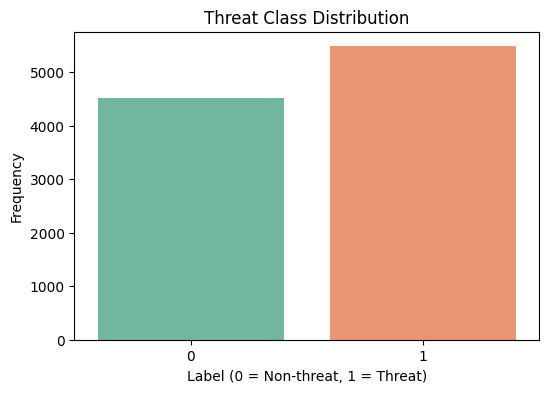

Non-Threat Posts: 4515 (45.15%)
Threat Posts: 5485 (54.85%)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Threat Class Distribution')
plt.xlabel('Label (0 = Non-threat, 1 = Threat)')
plt.ylabel('Frequency')
plt.show()

# Ratio of the distribution
non_threat = df[df['label'] == 0].shape[0]
threat = df[df['label'] == 1].shape[0]
total = df.shape[0]

print(f"Non-Threat Posts: {non_threat} ({round(non_threat/total*100, 2)}%)")
print(f"Threat Posts: {threat} ({round(threat/total*100, 2)}%)")


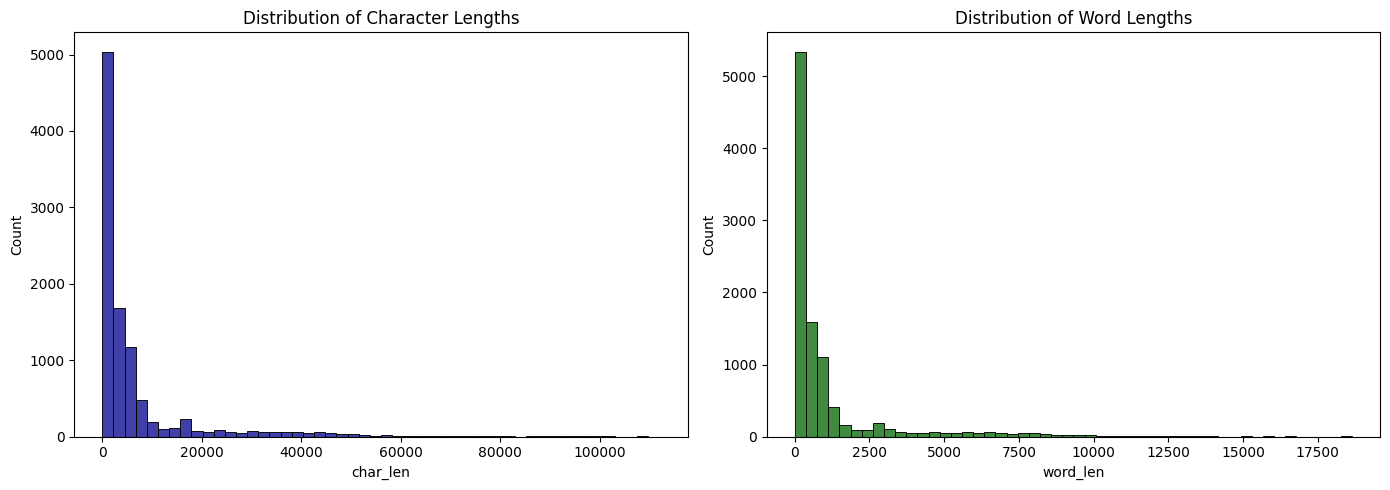

/tmp/ipython-input-7-795910269.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_len', data=df, palette='coolwarm')


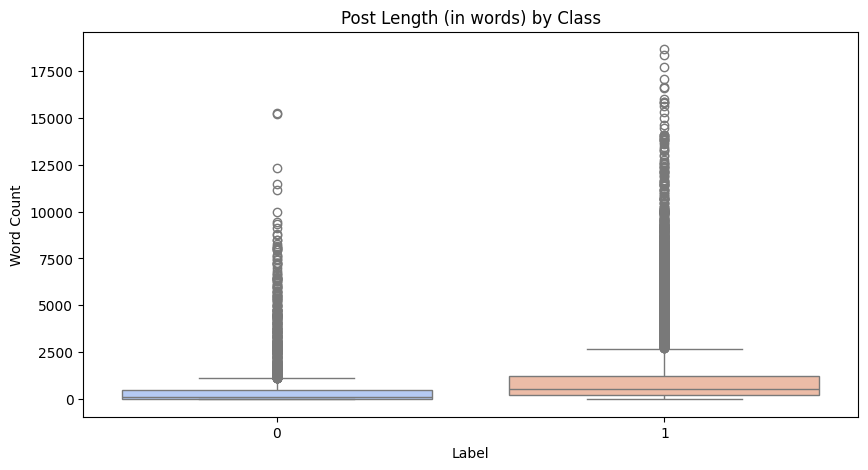

In [ ]:
# Adding the length column
df['char_len'] = df['clean_txt'].apply(len)
df['word_len'] = df['clean_txt'].apply(lambda x: len(x.split()))

# Histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['char_len'], bins=50, ax=axs[0], color='darkblue')
axs[0].set_title('Distribution of Character Lengths')

sns.histplot(df['word_len'], bins=50, ax=axs[1], color='darkgreen')
axs[1].set_title('Distribution of Word Lengths')

plt.tight_layout()
plt.show()

# Comparing by label
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='word_len', data=df, palette='coolwarm')
plt.title('Post Length (in words) by Class')
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 20 words:
 [('idnumber', 240636), ('porn', 211517), ('porno', 158529), ('free', 91333), ('video', 79945), ('sex', 57873), ('idtime', 41684), ('idgeneralmoney', 39645), ('teen', 36808), ('online', 33832), ('girl', 28800), ('videos', 26714), ('child', 25968), ('young', 24658), ('cp', 24411), ('idnumberidnumber', 22106), ('fuck', 19365), (',', 18706), ('boy', 18647), ('little', 18545)]


/tmp/ipython-input-8-3475780635.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words_df, palette='viridis')


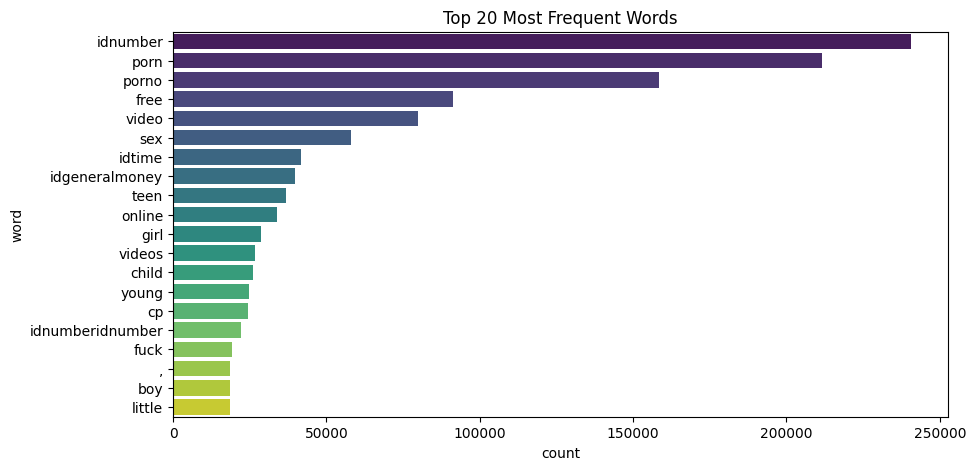

/tmp/ipython-input-8-3475780635.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='magma')


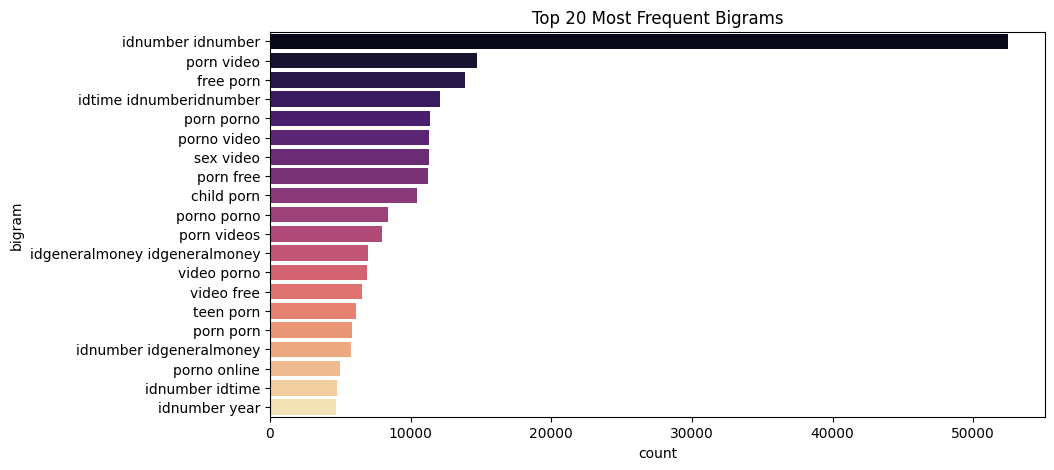

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tokenizing and filtering the stopwords
all_words = ' '.join(df['clean_txt']).lower().split()
filtered_words = [w for w in all_words if w not in stop_words]

# Displaying the Top unigrams
top_words = Counter(filtered_words).most_common(20)
print("Top 20 words:\n", top_words)

# Plotting the barplot
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=top_words_df, palette='viridis')
plt.title("Top 20 Most Frequent Words")
plt.show()

# Bigrams
tokens = [w for w in filtered_words if len(w) > 2]
bigrams = list(ngrams(tokens, 2))
bigram_freq = Counter(bigrams).most_common(20)

# Converting to strings
bigram_strings = [(' '.join(b), freq) for b, freq in bigram_freq]
bigram_df = pd.DataFrame(bigram_strings, columns=['bigram', 'count'])

# Plotting barplot
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='bigram', data=bigram_df, palette='magma')
plt.title("Top 20 Most Frequent Bigrams")
plt.show()


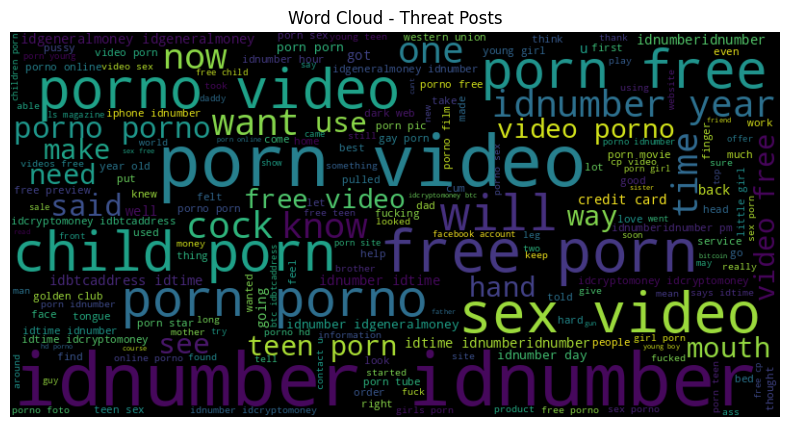

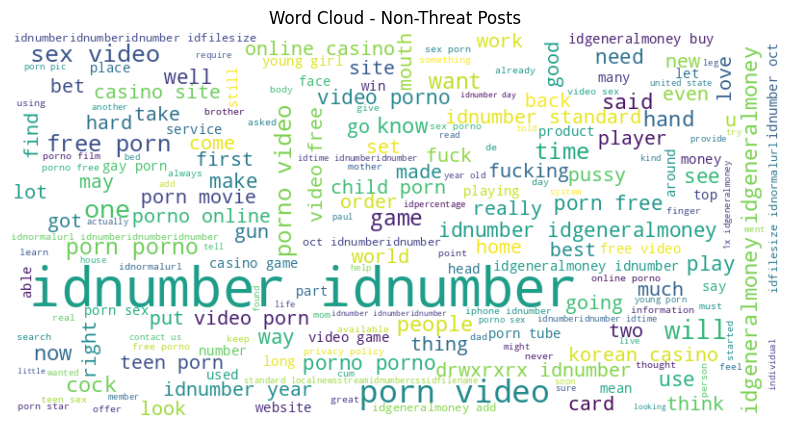

In [ ]:
from wordcloud import WordCloud

# Word Cloud for Threat Posts
threat_words = ' '.join(df[df['label'] == 1]['clean_txt'])
wordcloud_threat = WordCloud(width=800, height=400, background_color='black').generate(threat_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_threat, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Threat Posts")
plt.show()

# Word Cloud for Non-Threat Posts
non_threat_words = ' '.join(df[df['label'] == 0]['clean_txt'])
wordcloud_non_threat = WordCloud(width=800, height=400, background_color='white').generate(non_threat_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_non_threat, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Non-Threat Posts")
plt.show()


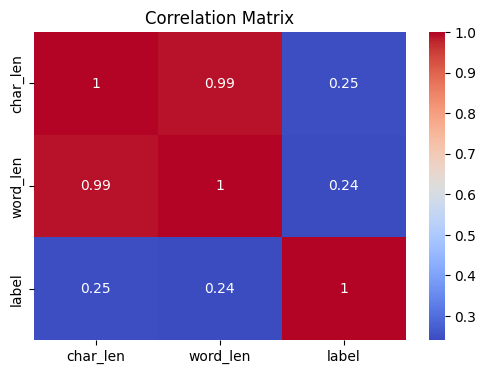

In [ ]:
import numpy as np

# Features correlation
corr = df[['char_len', 'word_len', 'label']].corr()

# plotting the Heatmap using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords') # downloading the stopwords
stop_words = set(stopwords.words('english'))

# Function to remove the stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])
df['clean_txt'] = df['clean_txt'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Defining the max number of words and sequence length
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LEN = 200

# Initializing the tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_txt'])

# Converting the texts to sequences
sequences = tokenizer.texts_to_sequences(df['clean_txt'])

# Padding sequences to same length
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# Previewing
print("Vocabulary Size:", len(tokenizer.word_index))
print("Padded Shape:", padded_sequences.shape)
print("Example sequence:\n", padded_sequences[0])


Vocabulary Size: 200505
Padded Shape: (10000, 200)
Example sequence:
 [ 115 2564 1582 2564  982 2564  414 2024 1155  134    2 2340    6 3428
   67    3 1155 2340 2191 1248  339    1  132  132    1 1155   13  194
  339  414 2024    1   46  132   46  414 2024  287  601  984 8985    1
 2260    1  878 1753 1334  984    1    1    1    1 2260    1  878  132
  132    1  241   67   46  132  194  339 6281 1224  241 2823    1  605
  386    1 6657 2398  976    1    1  845    1  567    2 1162    2    1
   69    1 5603  764 1426    1  506 6657 2398  976  512  246  918  512
  246    1    1    1 2615 4396    1  246 2200    1  865 2845    1  204
 3609    8 1258 3343   23  386  249  102 1343 6251   94 1244    1  386
 1556 9074 1491    1    1   29    1    1    1    8 8986  407    1  177
 2151 2564  691 1708 1042    1 8837   62   58  177 1576    1  567  593
 2450  227  921 3017  602  133    1   90 1483    1  220  119  220    1
    1 2541    1 3646    0    0    0    0    0    0    0    0    0    0
    0  

In [ ]:
# Displaying a sample of the key columns before and after cleaning
display_columns = ['txt', 'clean_txt', 'label', 'char_len', 'word_len']
df[display_columns].sample(10).reset_index(drop=True)

,txt,clean_txt,label,char_len,word_len
0,\n \n fake diplomatic camouflage passports for...,fake diplomatic camouflage passports sale pass...,0,4299,681
1,klls - kuffner local light server \n \n data l...,klls kuffner local light server data list stat...,0,22835,2498
2,login\nregister\nhidden answers\nwelcome to hi...,login register hidden answers welcome hidden a...,1,2827,428
3,\n \n wiki tor › welcome to wiki tor \n \n \n ...,wiki tor welcome wiki tor wiki tor easy way fi...,1,19527,2811
4,\n \n \n terrorist hitman \n \n terrorist hitm...,terrorist hitman terrorist hitman everyone wan...,1,673,112
5,\n \n \n mushroom summer首页 \n \n \n \n \n \n \...,"mushroom summer faq gpg ,tor,, idnumber lsd id...",0,133,15
6,\n \n \n p1 abgeschlossen \n \n \n \n congratu...,p1 abgeschlossen congratulations! exercise idn...,0,157,23
7,id_onion_url forum\nminibb ®\n| start | regist...,idonionurl forum minibb start register search ...,1,2664,313
8,\n log into facebook | facebook \n \n \n \n \n...,log facebook facebook remove help personalize ...,0,737,111
9,esp id_number веб сервер управления уличным ...,esp idnumber ds18b20 temp idnumber ds18b20 tem...,0,240,40


In [ ]:
df['clean_char_len'] = df['clean_txt'].apply(len)
df['clean_word_len'] = df['clean_txt'].apply(lambda x: len(x.split()))

# checking the statistics
df[['char_len', 'clean_char_len', 'word_len', 'clean_word_len']].describe()


,char_len,clean_char_len,word_len,clean_word_len
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,6650.956900,5362.338200,1094.964500,769.547800
std,12216.955217,9960.832943,2097.084766,1503.108761
min,0.000000,0.000000,0.000000,0.000000
25%,634.500000,525.000000,94.000000,71.000000
50%,2204.000000,1811.000000,331.500000,237.000000
75%,6085.750000,4743.500000,942.500000,632.000000
max,112071.000000,112071.000000,18648.000000,15198.000000


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# splitting as inputs and targets
X = padded_sequences
y = df['label'].values

# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Checking the shapes after splitting
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)


Training Set: (7000, 200) (7000,)
Validation Set: (1500, 200) (1500,)
Test Set: (1500, 200) (1500,)


## LSTM Implementation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

vocab_size = 10000
embedding_dim = 128
max_length = 200

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compiling
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 254ms/step - accuracy: 0.6594 - loss: 0.6431 - val_accuracy: 0.7087 - val_loss: 0.5554
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.7305 - loss: 0.5735 - val_accuracy: 0.7233 - val_loss: 0.5065
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 261ms/step - accuracy: 0.7668 - loss: 0.4568 - val_accuracy: 0.7660 - val_loss: 0.4886
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - accuracy: 0.8070 - loss: 0.3986 - val_accuracy: 0.7593 - val_loss: 0.5041
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 0.8044 - loss: 0.3648 - val_accuracy: 0.6973 - val_loss: 0.5844


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Performace metrics for LSTM Model
Accuracy:  0.7907
Precision: 0.7755
Recall:    0.8698
F1 Score:  0.8200


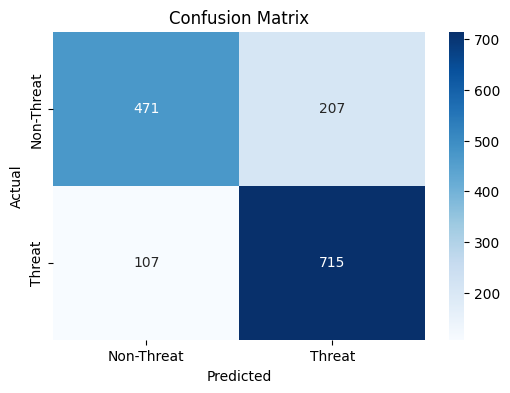


Classification Report for LSTM:
              precision    recall  f1-score   support

  Non-Threat       0.81      0.69      0.75       678
      Threat       0.78      0.87      0.82       822

    accuracy                           0.79      1500
   macro avg       0.80      0.78      0.78      1500
weighted avg       0.79      0.79      0.79      1500



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicting the probabilities on test set
y_pred_probs = model.predict(X_test)

# Converting the probabilities to binary labels
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Evaluating using the performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Performace metrics for LSTM Model")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Threat', 'Threat'], yticklabels=['Non-Threat', 'Threat'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Detailed classification report
print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred, target_names=['Non-Threat', 'Threat']))


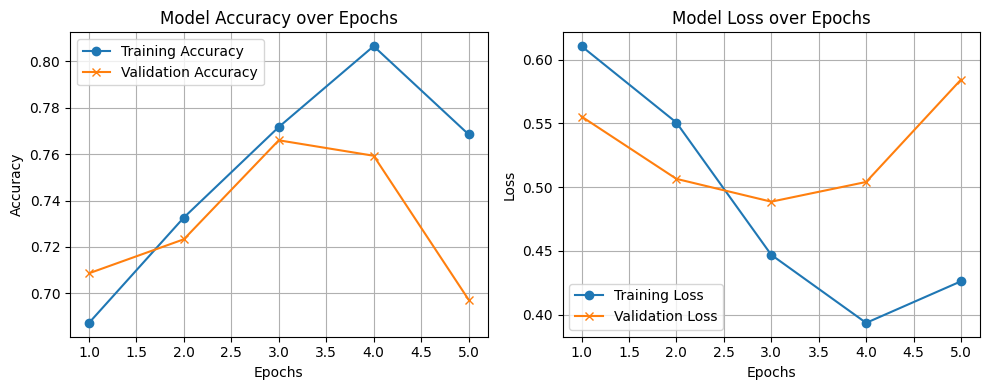

In [ ]:
import matplotlib.pyplot as plt

# Retrieving the training history for plotting loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting the Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting the Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## BERT Implementation

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Splitting manually
train_texts = df.iloc[:7000]['clean_txt'].tolist()
val_texts   = df.iloc[7000:8500]['clean_txt'].tolist()
test_texts  = df.iloc[8500:]['clean_txt'].tolist()

train_labels = torch.tensor(df.iloc[:7000]['label'].tolist())
val_labels   = torch.tensor(df.iloc[7000:8500]['label'].tolist())
test_labels  = torch.tensor(df.iloc[8500:]['label'].tolist())

# Tokenizing
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

train_enc = tokenize_data(train_texts)
val_enc   = tokenize_data(val_texts)
test_enc  = tokenize_data(test_texts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Wrapping the tokenized inputs and labels into PyTorch Datasets and DataLoaders for model training

In [ ]:
# Importing necessary classes for creating custom datasets and data loaders
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Defining a custom dataset class for handling the threat detection data
class ThreatDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ThreatDataset(train_enc, train_labels)
val_dataset   = ThreatDataset(val_enc, val_labels)
test_dataset  = ThreatDataset(test_enc, test_labels)

# Wrapping the datasets in DataLoader objects to enable batch processing and shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Shuffling for training
val_loader   = DataLoader(val_dataset, batch_size=16) # No shuffle for validation
test_loader  = DataLoader(test_dataset, batch_size=16) # No shuffle for validation


### Loading the BERT model for binary classification

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()


Using: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Importing required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Training the BERT model over multiple epochs and evaluating on the validation set after each epoch

In [ ]:
epochs = 3

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train() #Setting the model to training mode
    total_loss = 0

    #Loop through the training batches
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        #Backward pass and optimization step
        loss.backward()
        optimizer.step()

    print(f"Avg Training Loss: {total_loss/len(train_loader):.4f}")

    #For Validation
    model.eval()
    val_preds, val_labels_list = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()

            val_preds.extend(preds)
            val_labels_list.extend(labels.cpu().numpy())

    #Calculating and printing validation metrics
    acc = accuracy_score(val_labels_list, val_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(val_labels_list, val_preds, average='binary')
    print(f"Validation Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")



Epoch 1/3
Avg Training Loss: 0.4129
Validation Accuracy: 0.8427 | Precision: 0.8550 | Recall: 0.8710 | F1: 0.8630

Epoch 2/3
Avg Training Loss: 0.2634
Validation Accuracy: 0.8627 | Precision: 0.9342 | Recall: 0.8159 | F1: 0.8711

Epoch 3/3
Avg Training Loss: 0.1986
Validation Accuracy: 0.8487 | Precision: 0.8717 | Recall: 0.8605 | F1: 0.8661



Test Accuracy:  0.8593
Test Precision: 0.8703
Test Recall:    0.8796
Test F1 Score:  0.8749


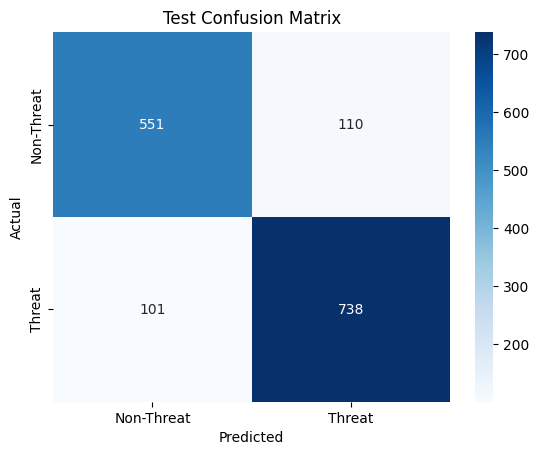


Classification Report:
              precision    recall  f1-score   support

  Non-Threat       0.85      0.83      0.84       661
      Threat       0.87      0.88      0.87       839

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



In [ ]:
#Evaluating on the trained model on the test set and displaying the performance metrics
model.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()

        test_preds.extend(preds)
        test_targets.extend(labels.cpu().numpy())

acc = accuracy_score(test_targets, test_preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_targets, test_preds, average='binary')
print(f"\nTest Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Threat', 'Threat'], yticklabels=['Non-Threat', 'Threat'])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=['Non-Threat', 'Threat']))


## SHAP Implementation for BERT (best performed mdoel)

In [ ]:
!pip install shap


In [ ]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TextClassificationPipeline

In [ ]:
# Loading the pretrained components
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to('cpu')  # SHAP works better on CPU

# Building the pipeline for text classification
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=-1)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Selecting the 5 clean text samples
sample_texts = df['clean_txt'].sample(5, random_state=42).tolist()


In [ ]:
# Using the shap.Explainer with transformers pipeline
explainer = shap.Explainer(pipe)

def truncate_text(text, max_tokens=510):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

# Applying to the selected texts
truncated_texts = [truncate_text(t) for t in df['clean_txt'].sample(5, random_state=42).tolist()]



In [ ]:
sample_texts = truncated_texts[:1]  # Applied to just one for now for compatibility
shap_values = explainer(sample_texts)
shap.plots.text(shap_values[0])


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [08:10, 490.14s/it]              


## Transformer Attention Analysis

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
text = "This message may contain a phishing attempt."
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=64)


In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of tensors (layers)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


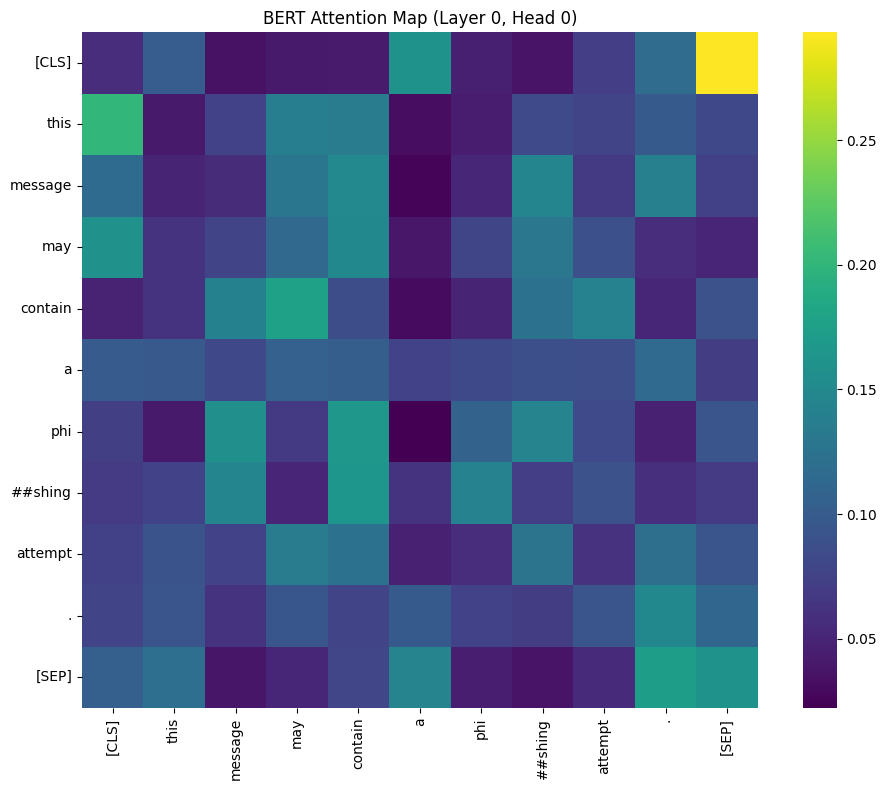

In [ ]:
# Getting the attention from layer 0, head 0
attention = attentions[0][0, 0].detach().numpy()  # (seq_len, seq_len)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(10, 8))
sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True)
plt.title("BERT Attention Map (Layer 0, Head 0)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
